<a href="https://colab.research.google.com/github/venkateshmedasani/ENHANCED-CALORIE-PREDICTION-MODEL/blob/Master/CALORIE_BURN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing required libraries

In [1]:
!pip install -q catboost xgboost lightgbm transformers tensorflow graphviz


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns


c:\Anaconda\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Loading and merging datasets, creating one consolidated dataset with required attributes

In [4]:
import pandas as pd

# Load the datasets
calories_df = pd.read_csv('calories.csv')        # contains 'user_id', 'calories_burnt'
exercise_df = pd.read_csv('exercise.csv')        # contains 'user_id', 'date', 'latitude', 'longitude', etc.
weather_df = pd.read_csv('weather_data.csv')     # contains 'date', 'latitude', 'longitude', 'temperature'

# Merge calories and exercise data on 'user_id'
user_data_df = pd.merge(exercise_df, calories_df, on='User_ID', how='inner')

# Select only the 'Temperature_C' column from weather data
temperature_df = weather_df[['Temperature_C']]

# Randomly sample 15,000 values from temperature data for alignment purposes
sampled_temperature_df = temperature_df.sample(n=15000, random_state=42).reset_index(drop=True)

# Ensure both DataFrames have the same length
if len(user_data_df) == len(sampled_temperature_df):
    # Reset indices for alignment and add temperature to user data
    user_data_df = user_data_df.reset_index(drop=True)
    user_data_df['Environmental_Temperature'] = sampled_temperature_df['Temperature_C']

    # Save the new DataFrame to CSV
    user_data_df.to_csv('user_data_with_temperature.csv', index=False)
    print("New user_data_df saved as 'user_data_with_temperature.csv'")
else:
    print("The datasets do not have the same number of rows.")


New user_data_df saved as 'user_data_with_temperature.csv'


verifying new dataset generated

In [5]:
user_data_df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Environmental_Temperature
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0,16.296300
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0,11.114736
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0,25.639647
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0,30.696139
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0,-5.572413


Assigning required environmental temperature values to their corresponding attributes



In [6]:
# Load the dataset
df = pd.read_csv('user_data_with_temperature.csv')

# Define temperature ranges for extreme and moderate weather
extreme_temp_low_range = (-10, 0)    # Updated low extreme temperature range
extreme_temp_high_range = (35, 45)   # Updated high extreme temperature range
moderate_temp_center = 20            # Central value for moderate temperature
moderate_temp_variation = 5          # Variation for moderate temperatures

# Define duration thresholds
short_duration_threshold = 10  # Threshold for "short" duration (minutes)
long_duration_threshold = 25   # Threshold for "long" duration (minutes)

# Define conditions for assigning temperatures
conditions = [
    (df['Duration'] <= short_duration_threshold),  # Short duration for extreme weather
    (df['Duration'] >= long_duration_threshold)    # Long duration for moderate weather
]

# Define choices for temperature values based on conditions
choices = [
    np.random.choice([np.random.uniform(*extreme_temp_low_range),
                      np.random.uniform(*extreme_temp_high_range)]),  # Assign extreme temperature (low or high)
    np.random.uniform(moderate_temp_center - moderate_temp_variation,
                      moderate_temp_center + moderate_temp_variation)  # Assign moderate temperature
]

# Apply the conditions to assign new temperature values
df['Environmental_Temperature'] = np.select(conditions, choices, default=df['Environmental_Temperature'])

# Optional: round temperatures for easier interpretation
df['Environmental_Temperature'] = df['Environmental_Temperature'].round(2)

# Save the modified DataFrame back to CSV
df.to_csv('user_data_with_modified_temperature.csv', index=False)
print("Dataset updated with adjusted temperatures based on duration.")

Dataset updated with adjusted temperatures based on duration.


dropping user ID column, and replacing gender values male and female to binary values 1 and 0

In [7]:
df.drop(columns = ["User_ID"],axis=1,inplace =True)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Environmental_Temperature
0,0,68,190.0,94.0,29.0,105.0,40.8,231.0,23.90
1,0,20,166.0,60.0,14.0,94.0,40.3,66.0,11.11
2,0,69,179.0,79.0,5.0,88.0,38.7,26.0,42.71
3,0,34,179.0,71.0,13.0,100.0,40.5,71.0,30.70
4,0,27,154.0,58.0,10.0,81.0,39.8,35.0,42.71
...,...,...,...,...,...,...,...,...,...
14995,0,20,193.0,86.0,11.0,92.0,40.4,45.0,24.72
14996,0,27,165.0,65.0,6.0,85.0,39.2,23.0,42.71
14997,0,43,159.0,58.0,16.0,90.0,40.1,75.0,9.27
14998,0,78,193.0,97.0,2.0,84.0,38.3,11.0,42.71


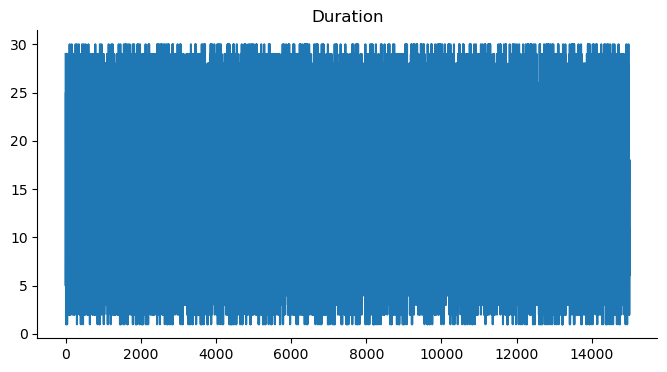

In [8]:
from matplotlib import pyplot as plt
df['Duration'].plot(kind='line', figsize=(8, 4), title='Duration')
plt.gca().spines[['top', 'right']].set_visible(False)

Clustering the attribute instances and finding correlation between the attributes for verification for calorie prediction

Correlation between Temperature and Calories Burned:
-0.44070364815917507
K-Means Cluster Summary:
                Heart_Rate    Calories   Duration  Environmental_Temperature  \
KMeans_Cluster                                                                 
0                88.146032   33.368571   7.788571                  42.267333   
1               106.561294  171.197794  25.791928                  23.466864   
2                82.347826   10.777306   3.048780                  42.710000   
3                95.192252   83.431209  16.076756                  26.513700   
4                97.048242   94.712418  17.238406                   1.113489   

                Body_Temp  
KMeans_Cluster             
0               39.530254  
1               40.751968  
2               38.484624  
3               40.249276  
4               40.321008  


c:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Anaconda\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Anaconda\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass

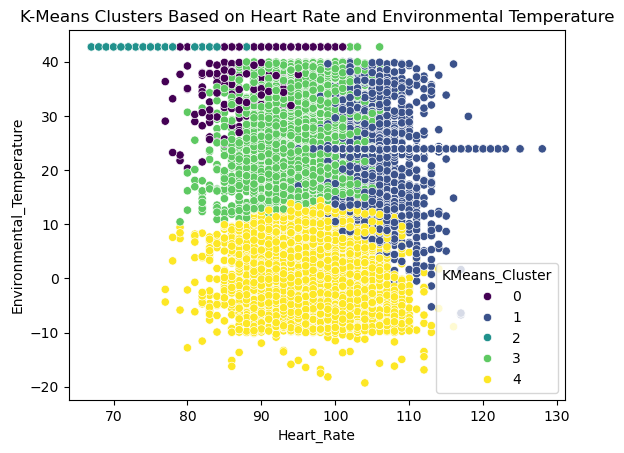

In [9]:
# Load the modified dataset with updated Environmental_Temperature
data = pd.read_csv('user_data_with_modified_temperature.csv')

# Display correlation between Environmental Temperature and Calories for verification
correlation_matrix = data[['Environmental_Temperature', 'Calories']].corr()
print("Correlation between Temperature and Calories Burned:")
print(correlation_matrix.loc['Environmental_Temperature', 'Calories'])

# Select relevant features for clustering
features = data[['Heart_Rate', 'Body_Temp', 'Duration', 'Environmental_Temperature']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### K-Means Clustering ###
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(features_scaled)

# Analyze K-Means clusters
kmeans_summary = data.groupby('KMeans_Cluster')[['Heart_Rate', 'Calories', 'Duration', 'Environmental_Temperature', 'Body_Temp']].mean()
print("K-Means Cluster Summary:")
print(kmeans_summary)

# Visualize the K-Means clusters
sns.scatterplot(data=data, x='Heart_Rate', y='Environmental_Temperature', hue='KMeans_Cluster', palette='viridis')
plt.title("K-Means Clusters Based on Heart Rate and Environmental Temperature")
plt.show()

bmr calculation for each instance

In [10]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('user_data_with_modified_temperature.csv')

# Define a function to calculate BMR based on gender
def calculate_bmr(row):
    if row['Gender'] == 1:  # Male
        return 88.362 + (13.397 * row['Weight']) + (4.799 * row['Height']) - (5.677 * row['Age'])
    else:  # Female
        return 447.593 + (9.247 * row['Weight']) + (3.098 * row['Height']) - (4.330 * row['Age'])

# Apply the function to each row and create a new 'BMR' column in the DataFrame
df['BMR'] = df.apply(calculate_bmr, axis=1)

# Display the first few rows to confirm BMR calculation
print(df[['Weight', 'Height', 'Age', 'Gender', 'BMR']].head())

# Optionally, save the updated DataFrame to a new CSV file
df.to_csv('user_data_with_bmr.csv', index=False)


   Weight  Height  Age  Gender       BMR
0    94.0   190.0   68    male  1610.991
1    60.0   166.0   20  female  1430.081
2    79.0   179.0   69    male  1433.878
3    71.0   179.0   34  female  1511.452
4    58.0   154.0   27  female  1344.101


In [11]:
# Assuming 'df' is your DataFrame with 'BMR' and other necessary columns
def calculate_relative_metabolic_rate(row):
    """Calculates the relative metabolic rate."""
    return row['Calories'] / row['BMR']

# Apply the function to create the 'Relative_Metabolic_Rate' column
df['Relative_Metabolic_Rate'] = df.apply(calculate_relative_metabolic_rate, axis=1)

# Display the first few rows to confirm the calculation
print(df[['Calories', 'BMR', 'Relative_Metabolic_Rate']].head())

# Save the updated DataFrame (optional)
df.to_csv('user_data_with_relative_metabolic_rate.csv', index=False)

   Calories       BMR  Relative_Metabolic_Rate
0     231.0  1610.991                 0.143390
1      66.0  1430.081                 0.046151
2      26.0  1433.878                 0.018133
3      71.0  1511.452                 0.046975
4      35.0  1344.101                 0.026040


Heatmap for visualizing correlation between all feautures

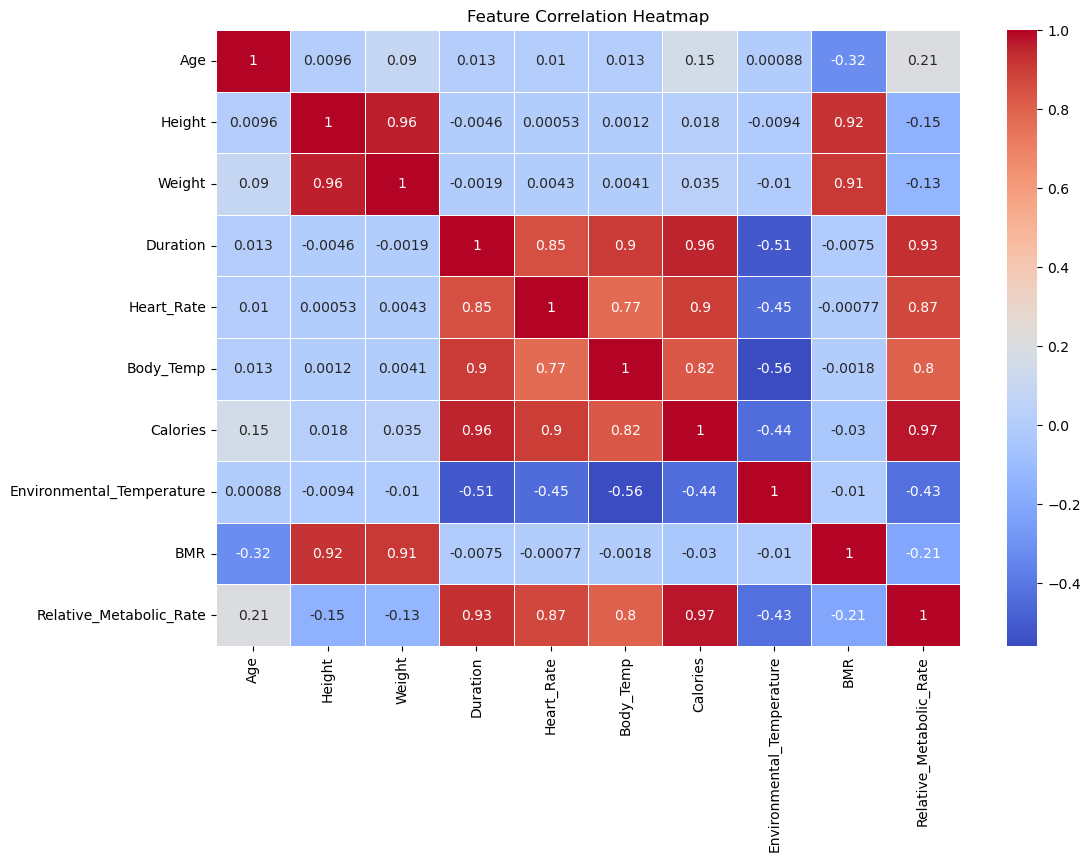

In [12]:
# Load the dataset
df = pd.read_csv('user_data_with_relative_metabolic_rate.csv')
df = df.drop(columns=['Gender', 'User_ID'])

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Title for heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

Correlation between Temperature and Calories Burned:
0.9738917739921229
K-Means Cluster Summary:
                Heart_Rate    Calories   Duration  Relative_Metabolic_Rate  \
KMeans_Cluster                                                               
0                88.146032   33.368571   7.788571                 0.022854   
1               106.561294  171.197794  25.791928                 0.116668   
2                82.347826   10.777306   3.048780                 0.007461   
3                95.192252   83.431209  16.076756                 0.056847   
4                97.048242   94.712418  17.238406                 0.064458   

                Body_Temp  
KMeans_Cluster             
0               39.530254  
1               40.751968  
2               38.484624  
3               40.249276  
4               40.321008  


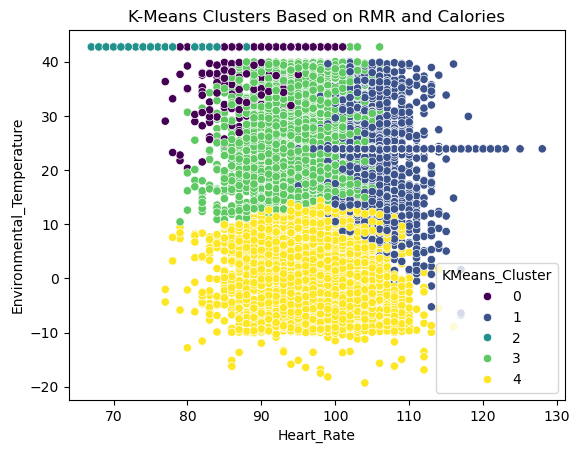

In [13]:
# Load the modified dataset with updated Environmental_Temperature
data = pd.read_csv('user_data_with_relative_metabolic_rate.csv')

# Display correlation between Environmental Temperature and Calories for verification
correlation_matrix = data[['Relative_Metabolic_Rate','Heart_Rate', 'Calories']].corr()
print("Correlation between Temperature and Calories Burned:")
print(correlation_matrix.loc['Relative_Metabolic_Rate', 'Calories'])

# Select relevant features for clustering
features = data[['Heart_Rate', 'Body_Temp', 'Duration', 'Environmental_Temperature']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### K-Means Clustering ###
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(features_scaled)

# Analyze K-Means clusters
kmeans_summary = data.groupby('KMeans_Cluster')[['Heart_Rate', 'Calories', 'Duration', 'Relative_Metabolic_Rate', 'Body_Temp']].mean()
print("K-Means Cluster Summary:")
print(kmeans_summary)

# Visualize the K-Means clusters
sns.scatterplot(data=data, x='Heart_Rate', y='Environmental_Temperature', hue='KMeans_Cluster', palette='viridis')
plt.title("K-Means Clusters Based on RMR and Calories")
plt.show()

boxplot for all features

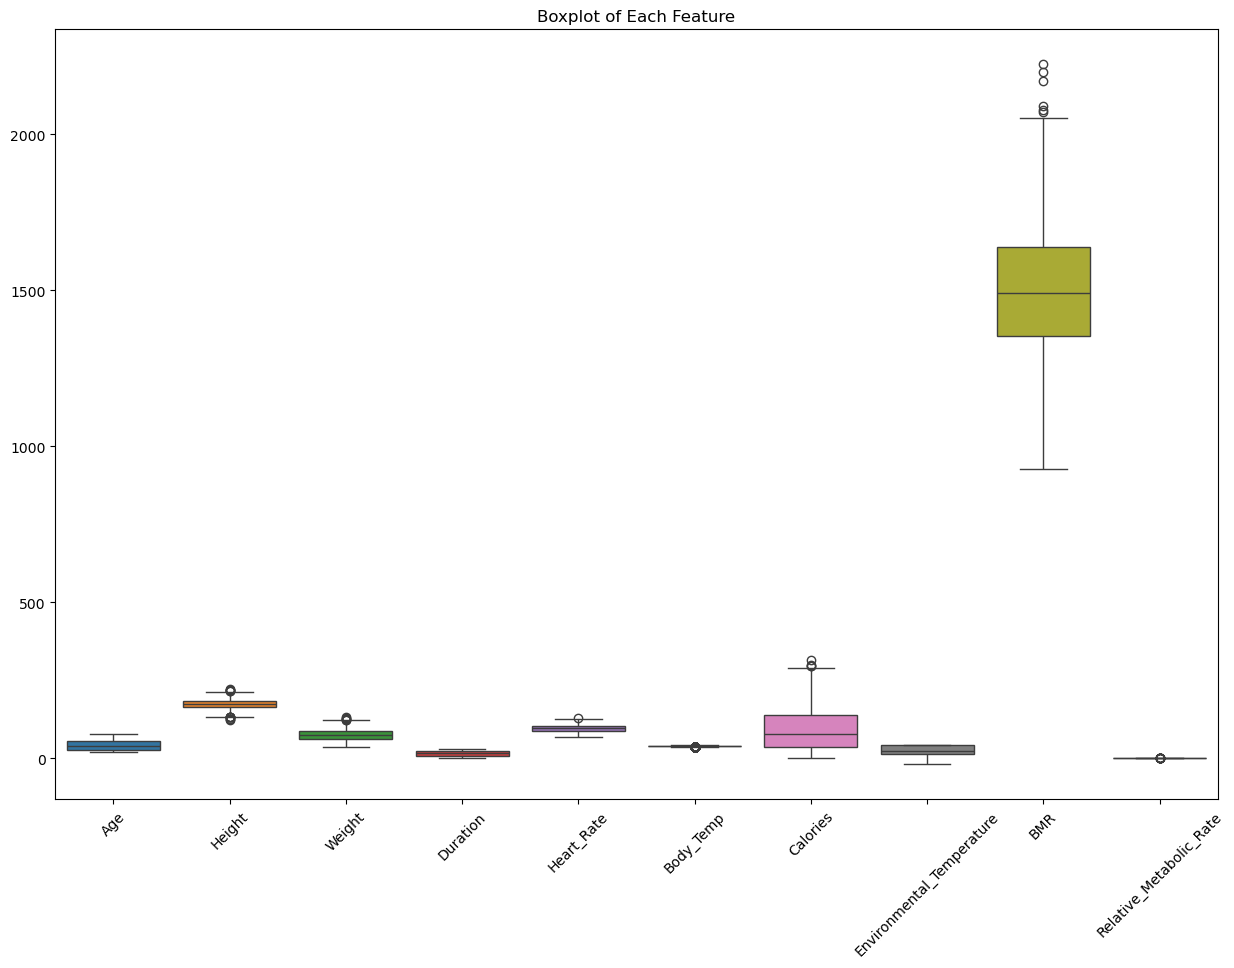

In [14]:
# Load the dataset
df = pd.read_csv('user_data_with_relative_metabolic_rate.csv')
df = df.drop(columns=['Gender', 'User_ID'])

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Create boxplots for each feature
sns.boxplot(data=df)

# Title for the plot
plt.title("Boxplot of Each Feature")
plt.xticks(rotation=45)  # Rotate feature names for better readability
plt.show()


Begin splitting the dataset for training and testing for prediction and drop Calories to make predictions

In [15]:
X = df.drop(columns = ["Calories","Relative_Metabolic_Rate"],axis = 1)
y = df["Calories"] #target variable that is to predict calories

In [16]:
# prompt: for data frame x and target df y, split into 70 15 15 training testing validation

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.15,random_state=1)
print("Shape of X Train: ",X_train.shape)
print("Shape of X Test: ",X_test.shape)
print("Shape of y Train: ",y_train.shape)
print("Shape of y Test: ",y_test.shape)

Shape of X Train:  (12750, 8)
Shape of X Test:  (2250, 8)
Shape of y Train:  (12750,)
Shape of y Test:  (2250,)


Prediction model along with relevant metrics and visualization

In [18]:
def prediction(ml_model):
    model=ml_model.fit(X_train,y_train)
    print('Score : {}'.format(model.score(X_train,y_train)))
    y_prediction=model.predict(X_test)
    print('predictions are: \n {}'.format(y_prediction))
    print('\n')

    r2_score=metrics.r2_score(y_test,y_prediction)
    print('r2 score: {}'.format(r2_score))

    print('MAE:',metrics.mean_absolute_error(y_test,y_prediction))
    print('MSE:',metrics.mean_squared_error(y_test,y_prediction))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))

    # sns.distplot(y_test-y_prediction)

    # Distribution plot of residuals
    sns.distplot(y_test - y_prediction)
    plt.title("Residuals Distribution")
    plt.show()

    # Scatter plot for Actual vs Predicted Calories
    plt.scatter(y_test, y_prediction, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title('Actual vs Predicted Calories')
    plt.show()

        # Check if the model has feature importances
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        features = X_train.columns

        # Create a DataFrame for plotting
        importance_df = pd.DataFrame({
            "Feature": features,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)

        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
        plt.title("Feature Importance for Calorie Prediction")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.show()
    else:
        print("Feature importance is not available for this model.")

Linear Regression

Score : 0.9689989711389095
predictions are: 
 [200.20447486  77.78849298 195.03910721 ... 127.31895735  37.77715501
  33.82186379]


r2 score: 0.9669183108939979
MAE: 8.276642671315365
MSE: 133.6656461845177
RMSE: 11.56138599755746


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


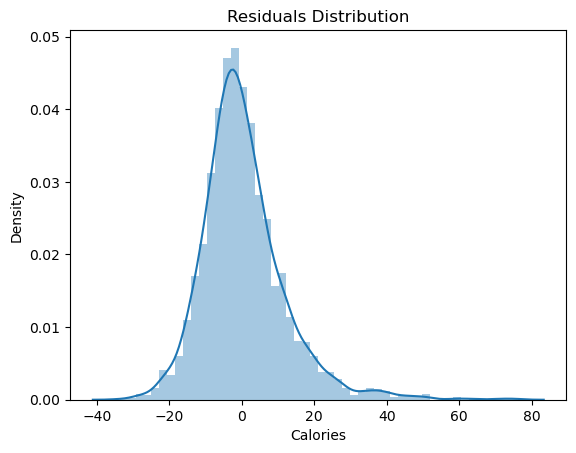

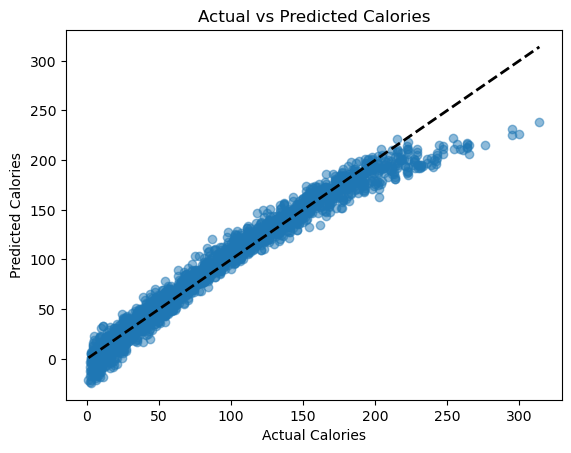

Feature importance is not available for this model.


In [19]:
prediction(LinearRegression())

XGB Regression

Score : 0.9987539439981018
predictions are: 
 [204.64828   69.12139  200.1334   ... 103.59975   29.67038   30.060947]


r2 score: 0.9952819986687784
MAE: 2.519002586947547
MSE: 19.062953364214234
RMSE: 4.366114217953331


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


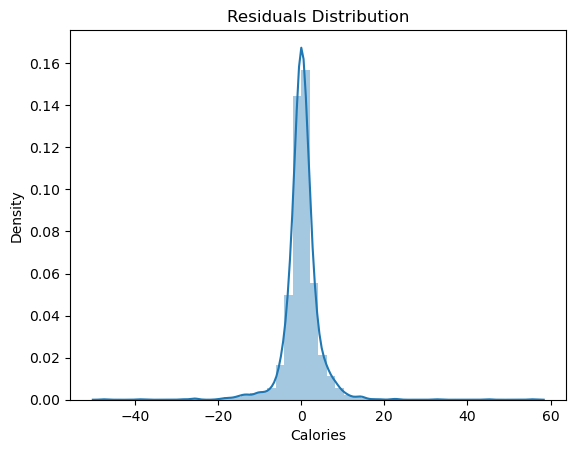

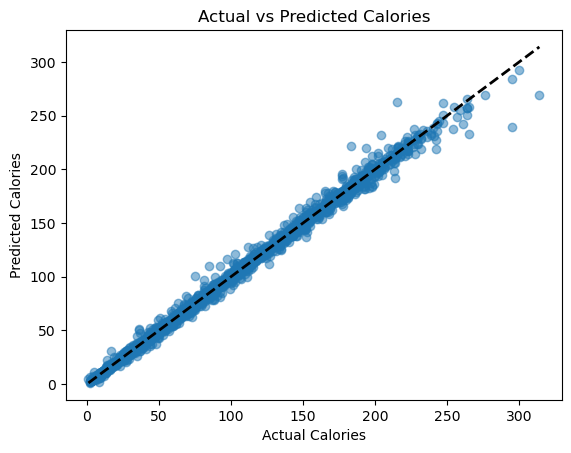

C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


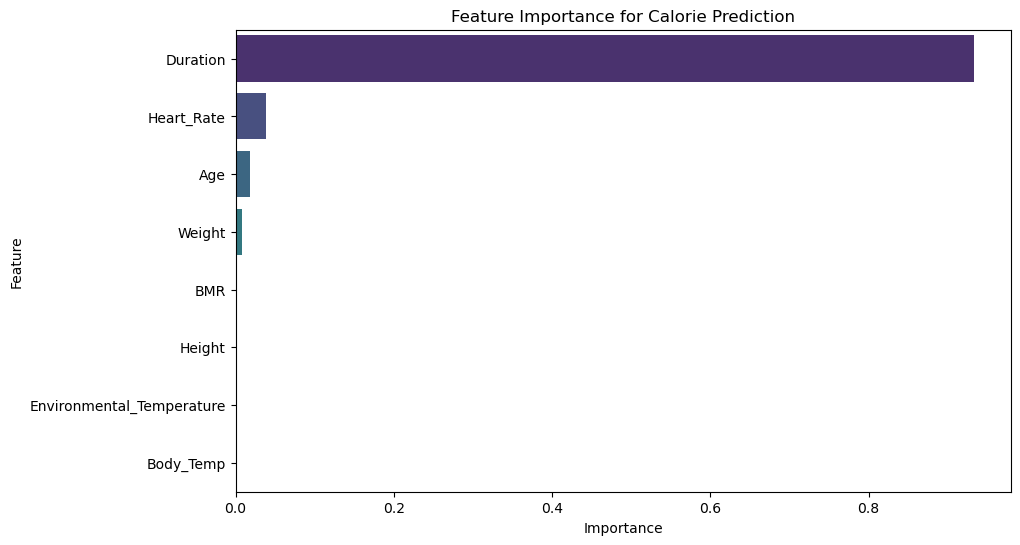

In [20]:
prediction(XGBRegressor())

Decision Tree regression

Score : 1.0
predictions are: 
 [201.  70. 211. ... 108.  31.  27.]


r2 score: 0.9870142791619728
MAE: 4.337777777777778
MSE: 52.468444444444444
RMSE: 7.243510505579766


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


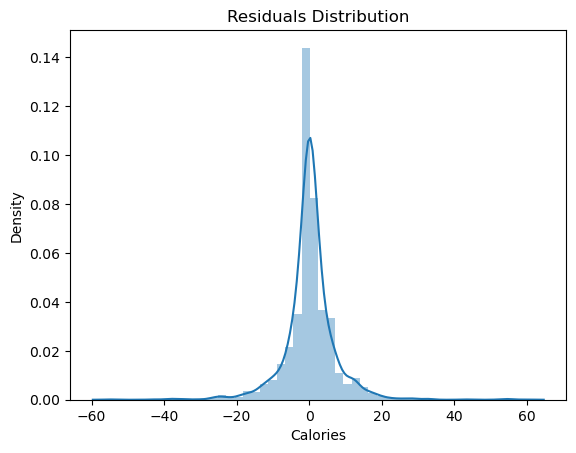

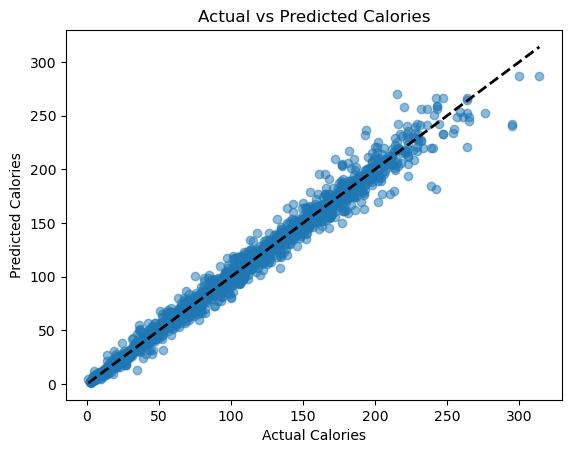

C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


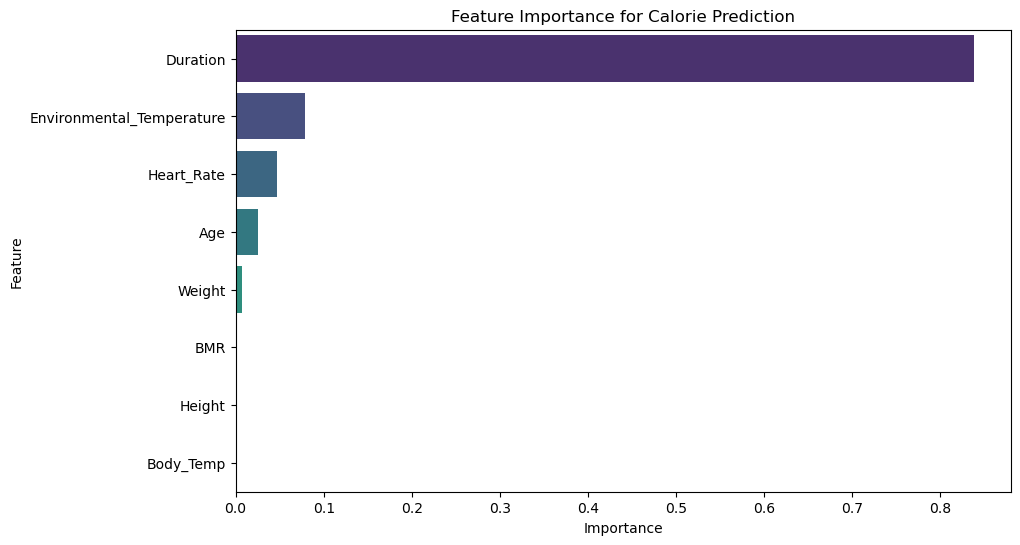

In [21]:
prediction(DecisionTreeRegressor())

Random Forest Regression

Score : 0.9992445681308221
predictions are: 
 [199.42  66.13 196.88 ... 113.4   32.82  28.17]


r2 score: 0.9948448084259472
MAE: 2.559986666666666
MSE: 20.829408400000002
RMSE: 4.56392467071927


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


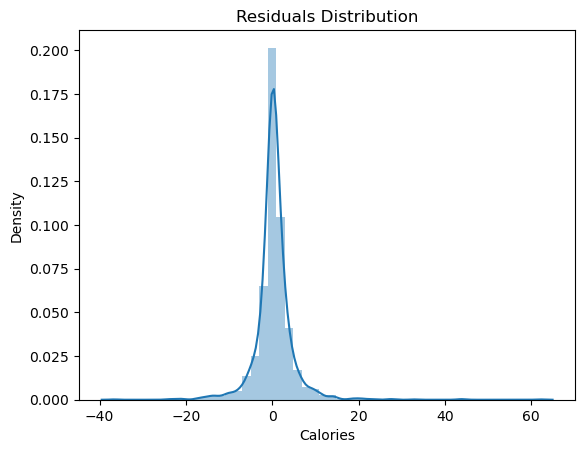

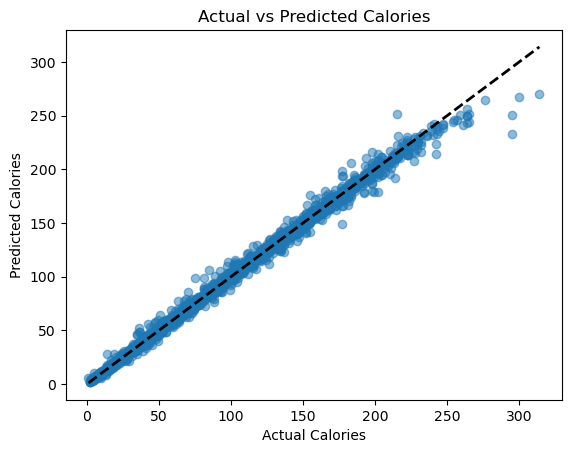

C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


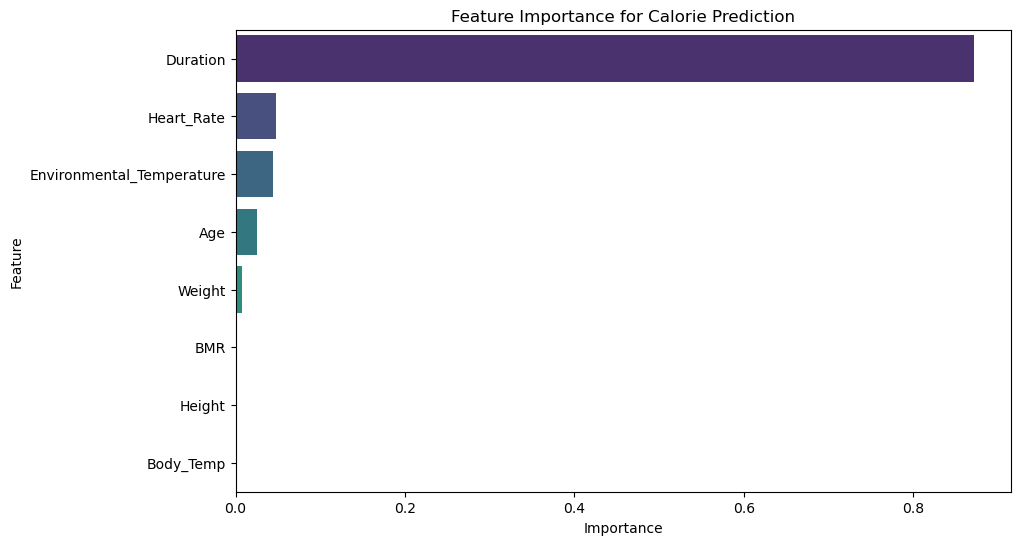

In [22]:

model = RandomForestRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [None],  # Limits the depth of each tree
    'min_samples_split': [2],  # Minimum samples required to split an internal node
    'n_estimators': [200]        # Number of trees in the forest
}

prediction(RandomForestRegressor())

Lasso regression

Score : 0.9689700371777207
predictions are: 
 [200.05915475  77.73629278 194.35079158 ... 127.33766129  37.85919269
  33.92572928]


r2 score: 0.9668330992555988
MAE: 8.275004294079086
MSE: 134.00994144322016
RMSE: 11.576266299771277


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


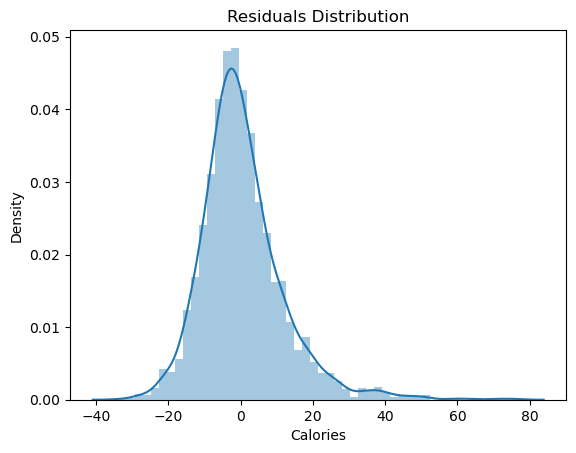

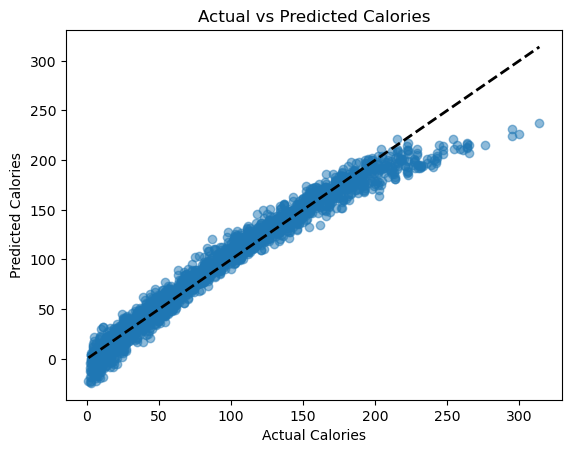

Feature importance is not available for this model.


In [23]:

lasso = Lasso(alpha=0.1)  # You can adjust the alpha parameter
prediction(lasso)

ridge regression

Score : 0.9689989675325896
predictions are: 
 [200.20323855  77.78848497 195.03213015 ... 127.31897104  37.77826388
  33.82381927]


r2 score: 0.9669177876937861
MAE: 8.276582419785464
MSE: 133.66776016044486
RMSE: 11.561477421179564


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


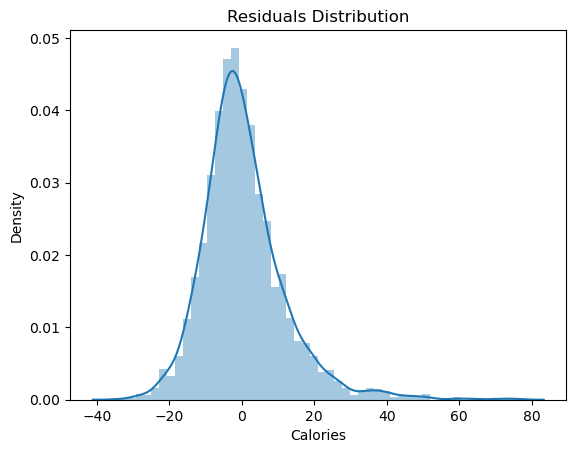

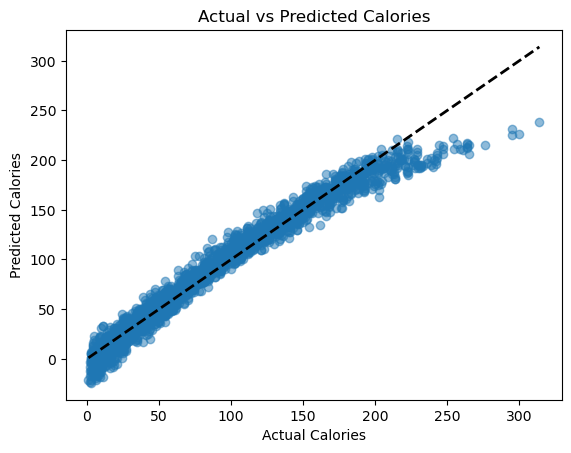

Feature importance is not available for this model.


In [24]:
ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter
prediction(ridge)

elastic net regression

Score : 0.9639076222163545
predictions are: 
 [197.79759858  77.9610814  185.81111618 ... 126.42079674  39.1855849
  35.90219251]


r2 score: 0.9614093080605252
MAE: 9.101426366353722
MSE: 155.92461915318853
RMSE: 12.486977983210691


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


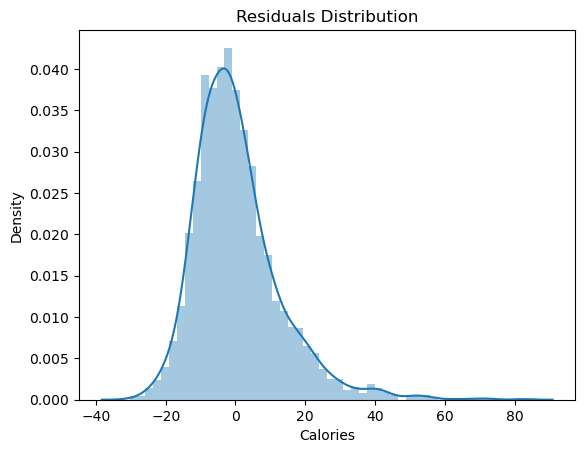

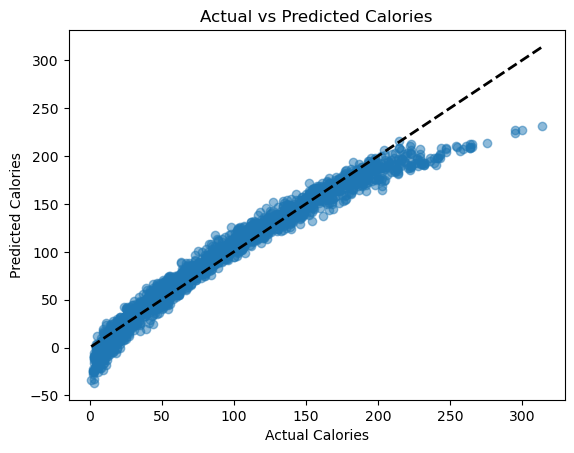

Feature importance is not available for this model.


In [25]:
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)  # You can adjust alpha and l1_ratio
prediction(elastic_net)

light gbm

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 874
[LightGBM] [Info] Number of data points in the train set: 12750, number of used features: 8
[LightGBM] [Info] Start training from score 89.204078
Score : 0.9975247484196359
predictions are: 
 [200.2091075   70.5228975  197.87708888 ... 104.87005123  29.79015406
  29.36391007]


r2 score: 0.9956424372367613
MAE: 2.321283153032317
MSE: 17.606611339329007
RMSE: 4.196023276785891


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


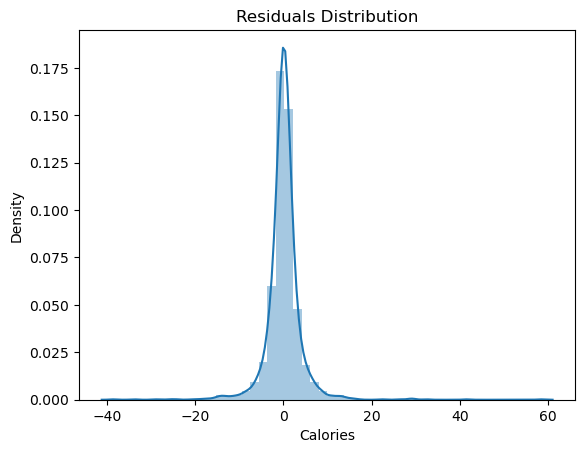

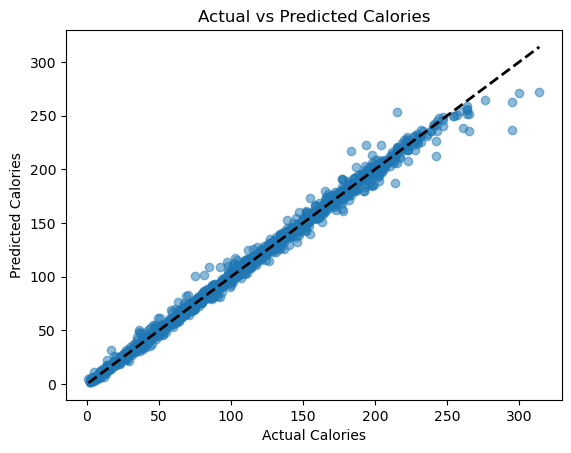

C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


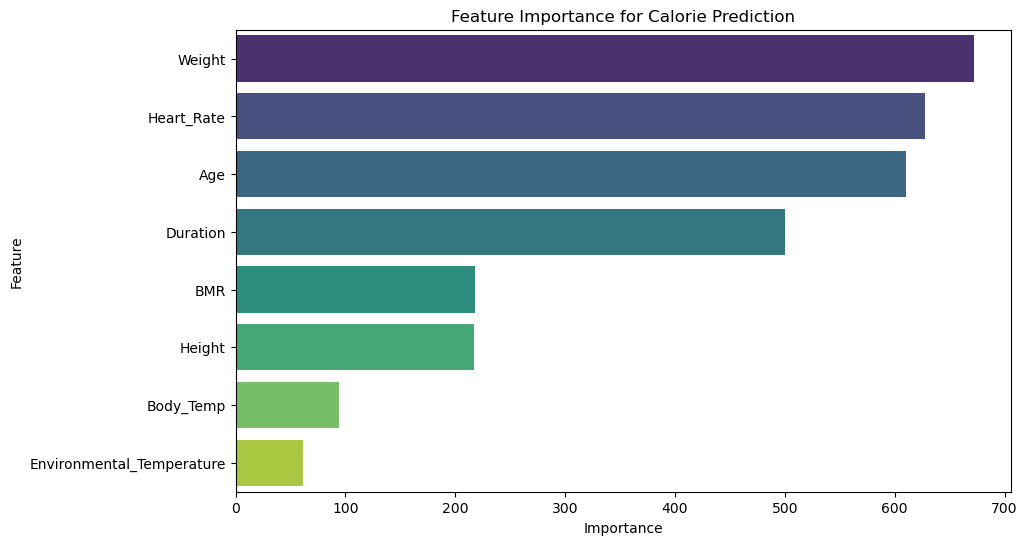

In [26]:
lgbm = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='l2')
prediction(lgbm)

catboost

Score : 0.9982198359160799
predictions are: 
 [202.75558155  71.45810708 194.95680936 ... 100.86663678  29.87467293
  28.82045735]


r2 score: 0.9966335167272724
MAE: 1.7338369565758218
MSE: 13.602182179290743
RMSE: 3.688113634270336


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_prediction)


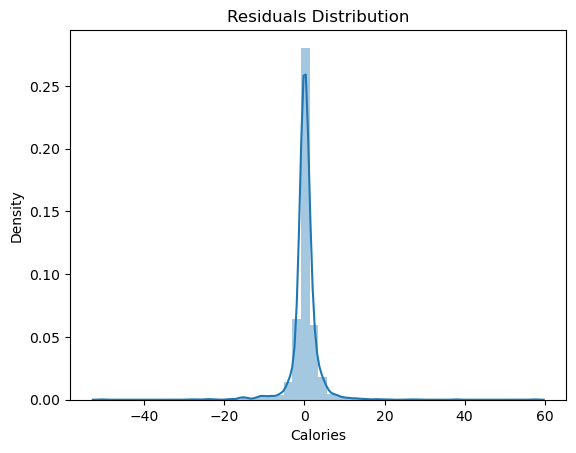

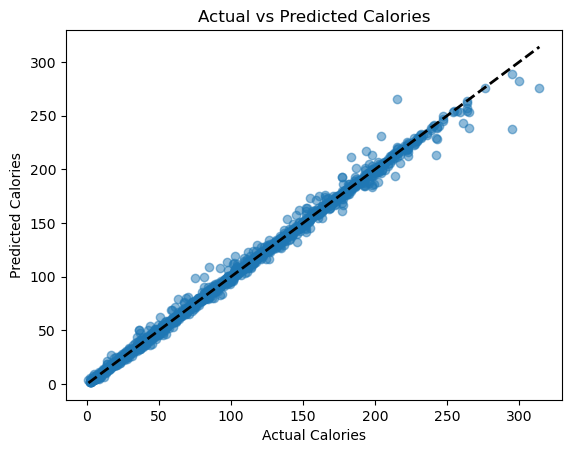

C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3063070253.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


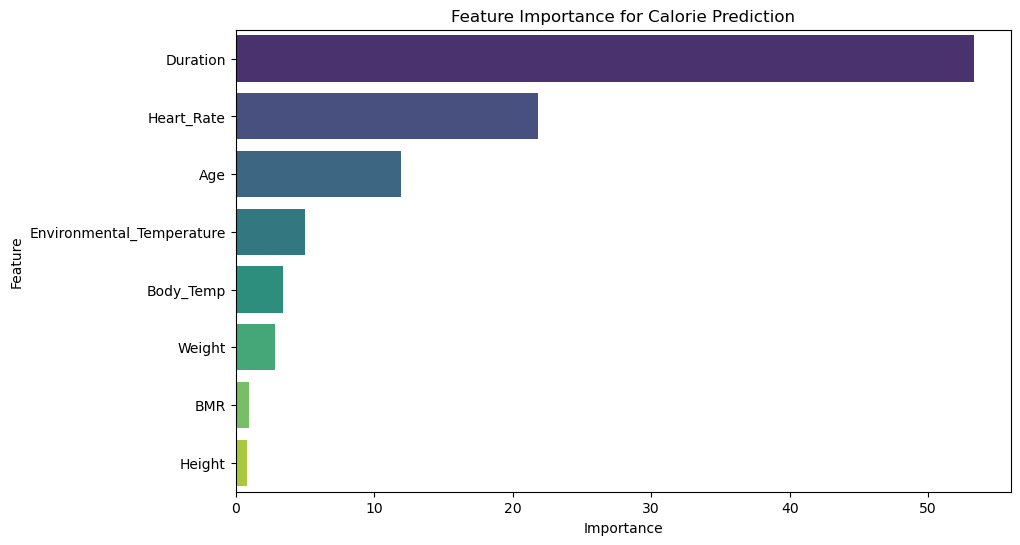

In [27]:
from catboost import CatBoostRegressor
catboost = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, verbose=0)
prediction(catboost)

Artificial Neural Netork section

In [28]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# ANN model
def build_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the ANN model
ann_model = build_ann_model(X_train_scaled.shape[1])
ann_model.summary()


c:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Function to train and evaluate a deep learning model
def train_and_evaluate(model, X_train, X_test, y_train, y_test):
    # Fit the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

    # Plot loss curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.title('Loss Curve')
    plt.show()

    # Predict and evaluate
    y_pred = model.predict(X_test)
    r2_score = metrics.r2_score(y_test, y_pred)
    print('R2 Score:', r2_score)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

    # Plotting residuals
    sns.distplot(y_test - y_pred.flatten())
    plt.title("Residuals Distribution")
    plt.show()

    # Scatter plot for Actual vs Predicted Calories
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual Calories')
    plt.ylabel('Predicted Calories')
    plt.title('Actual vs Predicted Calories')
    plt.show()


Training ANN Model
Epoch 1/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 2406.1714 - mae: 31.6702 - val_loss: 156.5660 - val_mae: 8.6020
Epoch 2/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 69.6992 - mae: 5.8530 - val_loss: 59.9196 - val_mae: 5.4092
Epoch 3/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 47.0203 - mae: 4.9975 - val_loss: 46.2495 - val_mae: 4.8381
Epoch 4/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 38.2352 - mae: 4.5064 - val_loss: 35.6155 - val_mae: 4.2470
Epoch 5/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 31.0326 - mae: 4.0124 - val_loss: 31.0741 - val_mae: 4.0603
Epoch 6/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 27.4818 - mae: 3.7240 - val_loss: 24.2659 - val_mae: 3.3396
Epoch 7/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 25.1786 - mae: 3.5001 - val_loss: 24.8641 - val_mae: 3.2910
Epoch 8/100
399/399 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.8685 - mae: 3.2917 - val_loss: 21.2269 - val_mae: 2.

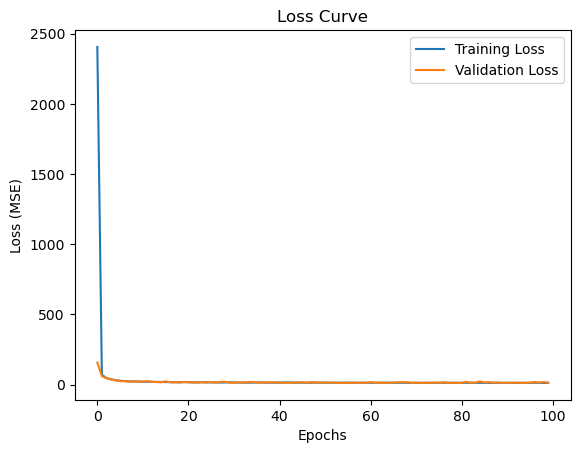

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step
R2 Score: 0.9966747251775796
MAE: 1.9129620621999104
MSE: 13.43568058014565
RMSE: 3.665471399444504


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\724188232.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred.flatten())


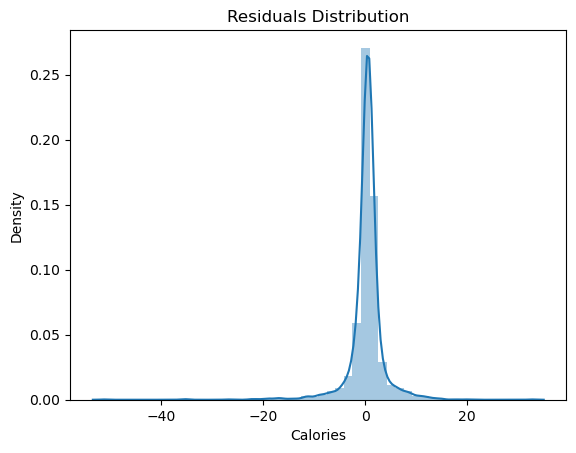

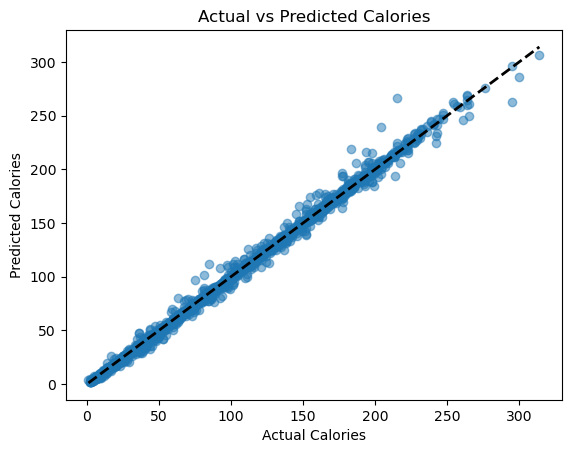

In [31]:
print("Training ANN Model")
train_and_evaluate(ann_model, X_train_scaled, X_test_scaled, y_train, y_test)


Epoch 1/100


c:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2738.8381 - mae: 35.1796 - val_loss: 274.5267 - val_mae: 11.8630
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 155.1965 - mae: 8.4756 - val_loss: 83.2845 - val_mae: 6.4935
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 65.7794 - mae: 5.7969 - val_loss: 56.9464 - val_mae: 5.1420
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - loss: 48.4239 - mae: 4.9528 - val_loss: 49.7674 - val_mae: 5.3445
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 40.1438 - mae: 4.4936 - val_loss: 35.0829 - val_mae: 4.1235
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 32.6791 - mae: 4.0510 - val_loss: 31.9870 - val_mae: 3.7997
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 28.5503 - mae: 3.7293 - val_loss: 25.8371 - val_mae: 3.4071
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 24.8253 - mae: 3.4111 - val_loss: 24.8850 - val_mae: 3.3244
Epoch 9/100
319/319 ━━━━

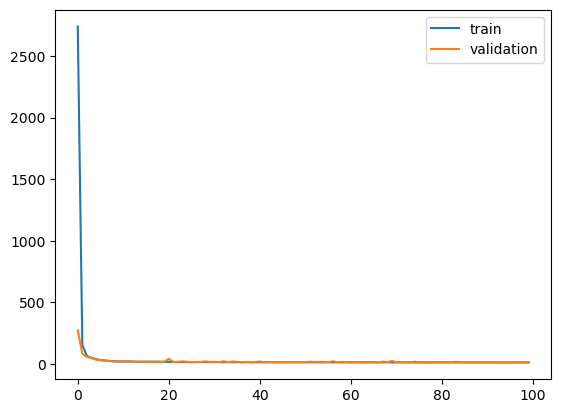

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
R^2 Score: 0.9967284749728165
Mean Absolute Error: 1.8573075906435648
Mean Squared Error: 13.218506025073989
Root Mean Squared Error: 3.635726340784464


C:\Users\parim\AppData\Local\Temp\ipykernel_26860\3480726032.py:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred.flatten())


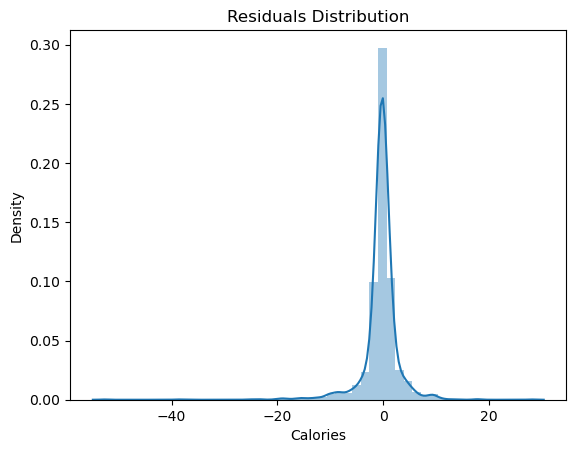

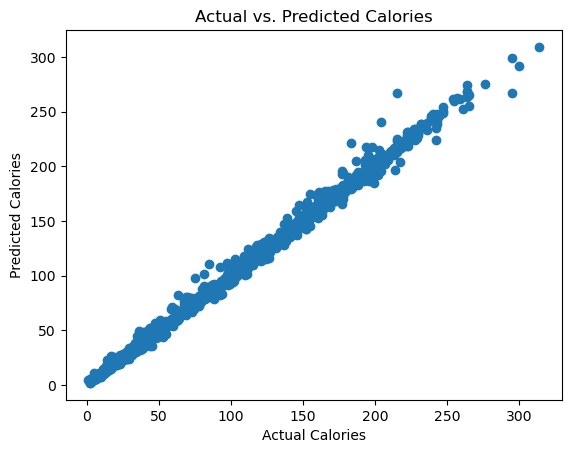

In [32]:
# prompt: Generate transforms deep learning model similar to above cell to make prediction

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Assuming X_train, X_test, y_train, y_test are already defined from the previous code

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Define the model
def build_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

ann_model = build_ann_model(X_train_scaled.shape[1])

# Train the model
history = ann_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Make predictions
y_pred = ann_model.predict(X_test_scaled)

# Evaluate the model
print("R^2 Score:", metrics.r2_score(y_test, y_pred))
print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", metrics.mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Residuals distribution plot
sns.distplot(y_test - y_pred.flatten())
plt.title("Residuals Distribution")
plt.show()

# Actual vs Predicted Calories plot
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs. Predicted Calories")
plt.show()

Other models apart from regression

In [33]:
# Define the model
model = RandomForestRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, 20, None],  # Limits the depth of each tree
    'min_samples_split': [2, 5, 10, 15],  # Minimum samples required to split an internal node
    'n_estimators': [50, 100, 200]        # Number of trees in the forest
}


In [34]:
# Set up GridSearchCV with the model and parameter grid
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           cv=3, scoring='r2', n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best R2 Score:", grid_search.best_score_)


Fitting 3 folds for each of 60 candidates, totalling 180 fits
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best R2 Score: 0.9940561711501856


**Real time data prep for training**

In [36]:
# Load your dataframe
# Assuming 'df' is already loaded in your environment
# Drop the 'calories' column to create features (X) and target (y)
X = df.drop(columns=['Calories','Relative_Metabolic_Rate'])
y = df['Calories']

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the feature values (optional, depending on your Transformer model's tokenizer)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled features to DataFrame for easier integration with textual formats
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)


In [37]:
import os
print("os imported")


os imported


In [40]:
import os
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

# Create models directory
os.makedirs('models', exist_ok=True)

# Train and save Linear Regression
print("Training Linear Regression...")
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
joblib.dump(linear_reg_model, 'models/linear_regression.pkl')

# Train and save Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, 'models/random_forest.pkl')

# Train and save Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
joblib.dump(gb_model, 'models/gradient_boosting.pkl')

# Train and save XGBoost
print("Training XGBoost...")
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, 'models/xgboost.pkl')

# Train and save LightGBM
print("Training LightGBM...")
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
joblib.dump(lgb_model, 'models/lightgbm.pkl')

print("All models saved successfully!")


Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 871
[LightGBM] [Info] Number of data points in the train set: 10500, number of used features: 8
[LightGBM] [Info] Start training from score 89.016952
All models saved successfully!
